In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [19]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [20]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [26]:
def create_structure_model(window_size=33, n_features=12):
    """Model with stronger regularization to prevent overfitting"""
    
    inputs = tf.keras.layers.Input(shape=(window_size, n_features))
    
    # Initial regularization
    x = tf.keras.layers.BatchNormalization()(inputs)
    x = tf.keras.layers.Dropout(0.2)(x)  # Add initial dropout
    
    # Simplified convolutional layers with L2 regularization
    conv1 = tf.keras.layers.Conv1D(
        32, 3, 
        padding='same', 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    
    conv2 = tf.keras.layers.Conv1D(
        32, 5, 
        padding='same', 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    
    # Combine and normalize
    x = tf.keras.layers.Concatenate()([conv1, conv2])
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Simplified attention mechanism
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=2,  # Reduced number of heads
        key_dim=16,   # Reduced dimension
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x, x)
    
    x = tf.keras.layers.Add()([x, attention])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Focus on central residue with context
    central_pos = window_size // 2
    x = tf.keras.layers.Lambda(
        lambda x: x[:, central_pos-1:central_pos+2, :]
    )(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    # Simplified dense layers with strong regularization
    x = tf.keras.layers.Dense(
        64, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    x = tf.keras.layers.Dense(
        32, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

def create_structure_model(window_size=33, n_features=12):
    """Enhanced model architecture with multi-scale feature extraction"""
    
    inputs = tf.keras.layers.Input(shape=(window_size, n_features))
    
    # Initial feature processing
    x = tf.keras.layers.BatchNormalization()(inputs)
    
    # Multi-scale convolutions
    conv1 = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    conv3 = tf.keras.layers.Conv1D(32, 5, padding='same', activation='relu')(x)
    conv5 = tf.keras.layers.Conv1D(32, 7, padding='same', activation='relu')(x)
    
    # Combine multi-scale features
    x = tf.keras.layers.Concatenate()([conv1, conv3, conv5])
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Self-attention layer
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=4, key_dim=32
    )(x, x)
    x = tf.keras.layers.Add()([x, attention])
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Focus on central residue and context
    central_pos = window_size // 2
    x = tf.keras.layers.Lambda(
        lambda x: x[:, central_pos-2:central_pos+3, :]
    )(x)
    
    # Final feature processing
    x = tf.keras.layers.Flatten()(x)
    
    # Dense layers with skip connections
    x1 = tf.keras.layers.Dense(128, activation='relu')(x)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dropout(0.3)(x1)
    
    x2 = tf.keras.layers.Dense(128)(x1)
    x2 = tf.keras.layers.Add()([x1, x2])
    x2 = tf.keras.layers.Activation('relu')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)
    
    # Output
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def train_and_evaluate():
    """Main training and evaluation function"""
    
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("processed_data_train_after.csv")
    test_df = pd.read_csv("processed_data_test_after.csv")
    
    # Shuffle data
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Prepare data
    print("\nPreparing structure data...")
    X_train = prepare_structure_data(train_df)
    X_test = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    # Calculate class weights
    total = len(y_train)
    pos = np.sum(y_train == 1)
    neg = np.sum(y_train == 0)
    class_weights = {
        0: total / (2 * neg),
        1: total / (2 * pos)
    }
    print("\nClass weights:", class_weights)
    
    # Initialize cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train), 1):
        print(f"\nFold {fold}/5")
        
        # Create callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,          # Reduced patience
            restore_best_weights=True
        )
        
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,         # More aggressive reduction
            patience=3,         # Reduced patience
            min_lr=1e-6
        )
        
        # Create and compile model
        model = create_structure_model(
            window_size=X_train.shape[1],
            n_features=X_train.shape[2]
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(
                learning_rate=5e-4,    # Lower initial learning rate
                clipnorm=1.0
            ),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            X_train[train_idx], y_train[train_idx],
            batch_size=64,          # Increased batch size
            epochs=50,              # Reduced max epochs
            validation_data=(X_train[val_idx], y_train[val_idx]),
            callbacks=[early_stopping, lr_scheduler],
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict(X_test)
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Preparing structure data...

Training data shape: (8850, 33, 12)
Test data shape: (2737, 33, 12)

Class weights: {0: 1.0392202912165336, 1: 0.9636324041811847}

Fold 1/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.5196 - loss: 0.8908 - val_accuracy: 0.5774 - val_loss: 0.6904 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5570 - loss: 0.7571 - val_accuracy: 0.5514 - val_loss: 0.6996 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5883 - loss: 0.7091 - val_accuracy: 0.6028 - val_loss: 0.6788 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6143 - loss: 0.6697 - val_accuracy: 0.6079 - val_loss: 0.6786 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━

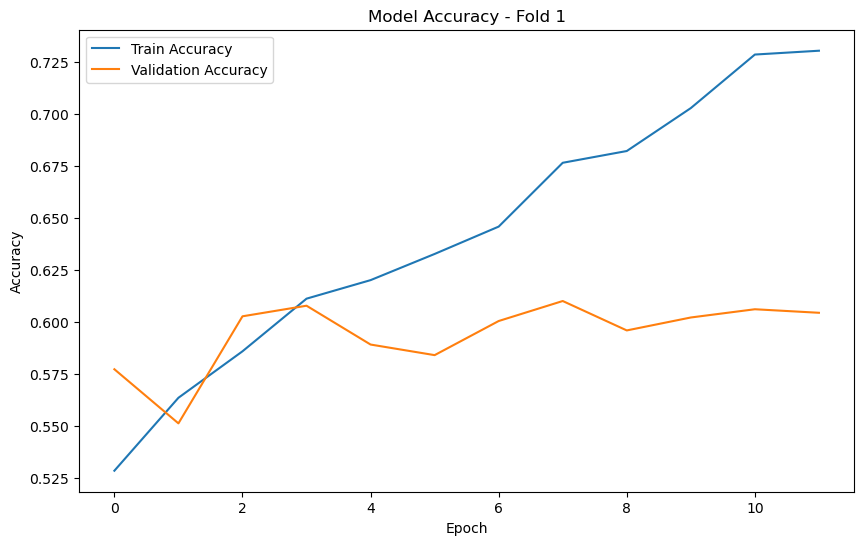

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.6006
Balanced Accuracy: 0.5961
MCC: 0.1927
Sensitivity: 0.6463
Specificity: 0.5459

Fold 2/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5219 - loss: 0.8798 - val_accuracy: 0.5836 - val_loss: 0.6895 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5849 - loss: 0.7229 - val_accuracy: 0.5746 - val_loss: 0.6985 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.5888 - loss: 0.7065 - val_accuracy: 0.5955 - val_loss: 0.6839 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.6168 - loss: 0.6630 - val_accuracy: 0.5859 - val_loss: 0.6859 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.6262 - loss: 0.6563 - val_accuracy: 0.5898 - val_loss: 0.6896 - learning_rate: 5.0000e-04
Epoch 6/50
111

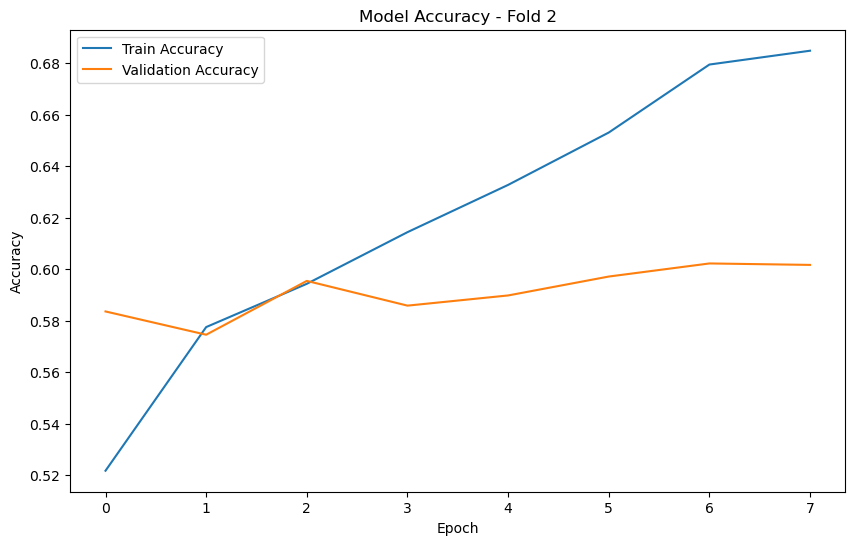

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.5955
Balanced Accuracy: 0.5905
MCC: 0.1834
Sensitivity: 0.6702
Specificity: 0.5108

Fold 3/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.5337 - loss: 0.8704 - val_accuracy: 0.5379 - val_loss: 0.7531 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.5718 - loss: 0.7531 - val_accuracy: 0.5768 - val_loss: 0.6902 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5914 - loss: 0.7030 - val_accuracy: 0.5774 - val_loss: 0.6783 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6122 - loss: 0.6856 - val_accuracy: 0.5944 - val_loss: 0.6703 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6103 - loss: 0.6675 - val_accuracy: 0.5921 - val_loss: 0.6685 - learning_rate: 5.0000e-04
Epoch 6/50
11

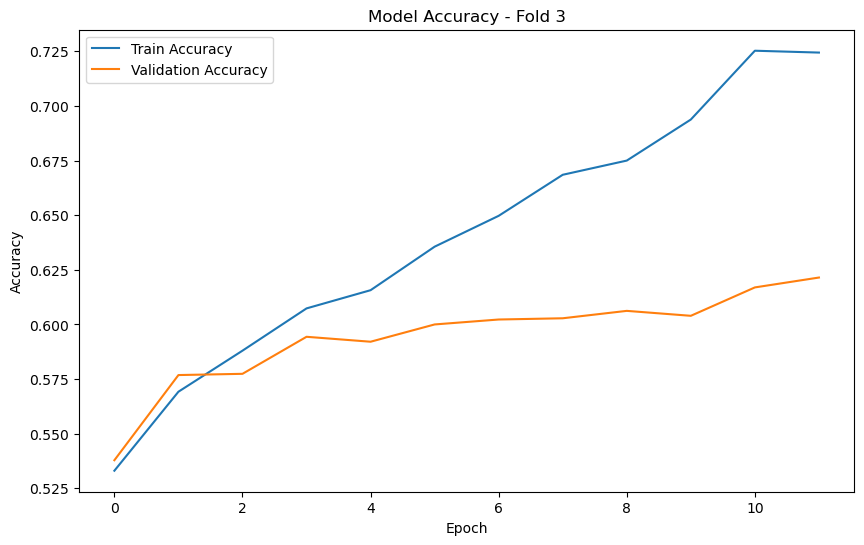

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.6023
Balanced Accuracy: 0.6020
MCC: 0.2044
Sensitivity: 0.6327
Specificity: 0.5713

Fold 4/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.5211 - loss: 0.8966 - val_accuracy: 0.5791 - val_loss: 0.6834 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5586 - loss: 0.7477 - val_accuracy: 0.5932 - val_loss: 0.6651 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5944 - loss: 0.7078 - val_accuracy: 0.6051 - val_loss: 0.6566 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6069 - loss: 0.6756 - val_accuracy: 0.6113 - val_loss: 0.6550 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6232 - loss: 0.6567 - val_accuracy: 0.6130 - val_loss: 0.6618 - learning_rate: 5.0000e-04
Epoch 6/50
11

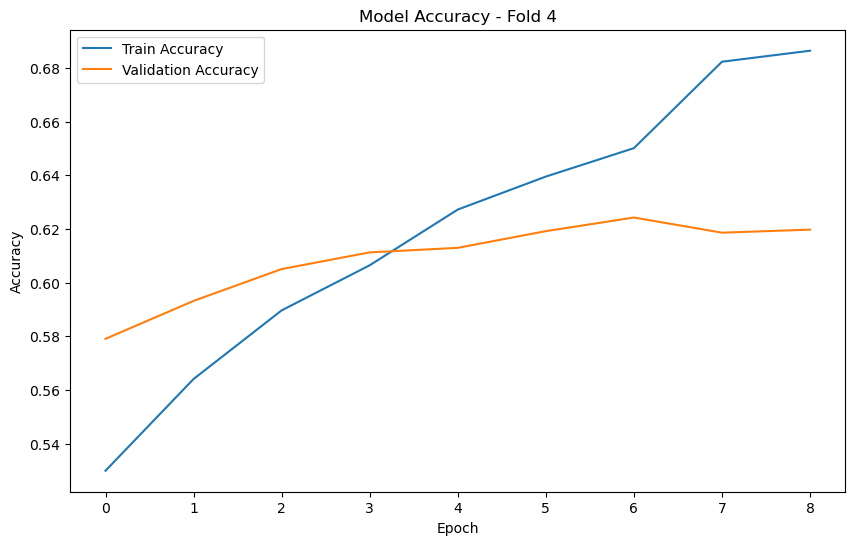

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 4 Results:
Accuracy: 0.6113
Balanced Accuracy: 0.6116
MCC: 0.2245
Sensitivity: 0.6633
Specificity: 0.5600

Fold 5/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.5247 - loss: 0.8898 - val_accuracy: 0.5678 - val_loss: 0.6976 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.5695 - loss: 0.7604 - val_accuracy: 0.5638 - val_loss: 0.7067 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5965 - loss: 0.7081 - val_accuracy: 0.5774 - val_loss: 0.6961 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.6038 - loss: 0.6867 - val_accuracy: 0.5887 - val_loss: 0.6865 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.6259 - loss: 0.6695 - val_accuracy: 0.5825 - val_loss: 0.6929 - learning_rate: 5.0000e-04
Epoch 6/50
11

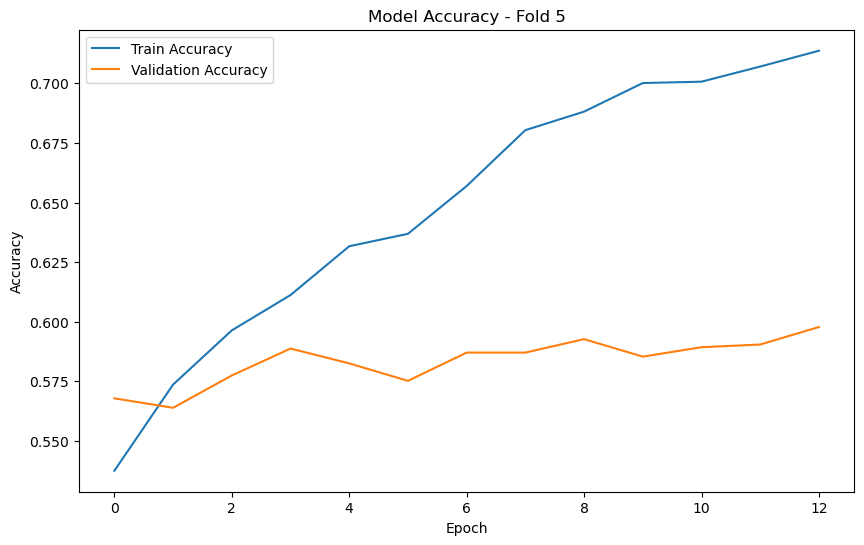

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.5870
Balanced Accuracy: 0.5866
MCC: 0.1732
Sensitivity: 0.5983
Specificity: 0.5749

Average Cross-validation Results:
ACC: 0.5993 ± 0.0080
BALANCED_ACC: 0.5974 ± 0.0088
MCC: 0.1956 ± 0.0177
SN: 0.6421 ± 0.0256
SP: 0.5526 ± 0.0232

Final Test Set Results:
Accuracy: 0.5944
Balanced Accuracy: 0.6064
MCC: 0.1217
Sensitivity: 0.6208
Specificity: 0.5919
Confusion Matrix:
[[1478 1019]
 [  91  149]]


In [28]:
if __name__ == "__main__":
    model = train_and_evaluate()

Simple Attention Model:

In [29]:
def create_structure_model(window_size=33, n_features=12):
    """Simple attention model"""
    inputs = tf.keras.layers.Input(shape=(window_size, n_features))
    
    # Initial processing
    x = tf.keras.layers.Dense(32, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Simple attention
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=2, 
        key_dim=16
    )(x, x)
    x = tf.keras.layers.Add()([x, attention])
    
    # Get central position
    central_pos = window_size // 2
    x = tf.keras.layers.Lambda(lambda x: x[:, central_pos, :])(x)
    
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Preparing structure data...

Training data shape: (8850, 33, 12)
Test data shape: (2737, 33, 12)

Class weights: {0: 1.0392202912165336, 1: 0.9636324041811847}

Fold 1/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5307 - loss: 0.7014 - val_accuracy: 0.5198 - val_loss: 0.6900 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5104 - loss: 0.6959 - val_accuracy: 0.5350 - val_loss: 0.6882 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5270 - loss: 0.6886 - val_accuracy: 0.5452 - val_loss: 0.6840 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5360 - loss: 0.6864 - val_accuracy: 0.5661 - val_loss: 0.6818 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━

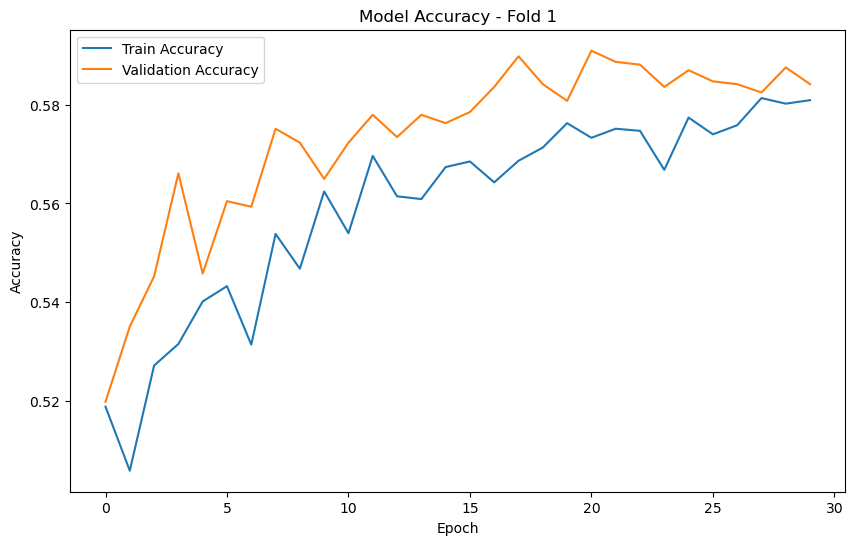

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 1 Results:
Accuracy: 0.5870
Balanced Accuracy: 0.5700
MCC: 0.1517
Sensitivity: 0.7604
Specificity: 0.3797

Fold 2/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5046 - loss: 0.6955 - val_accuracy: 0.5107 - val_loss: 0.6900 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5032 - loss: 0.6927 - val_accuracy: 0.5446 - val_loss: 0.6850 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.5243 - loss: 0.6881 - val_accuracy: 0.5706 - val_loss: 0.6828 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.5257 - loss: 0.6870 - val_accuracy: 0.5740 - val_loss: 0.6814 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5459 - loss: 0.6830 - val_accuracy: 0.5808 - val_loss: 0.6794 - learning_rate: 5.0000e-04
Epoch 6/50
111/

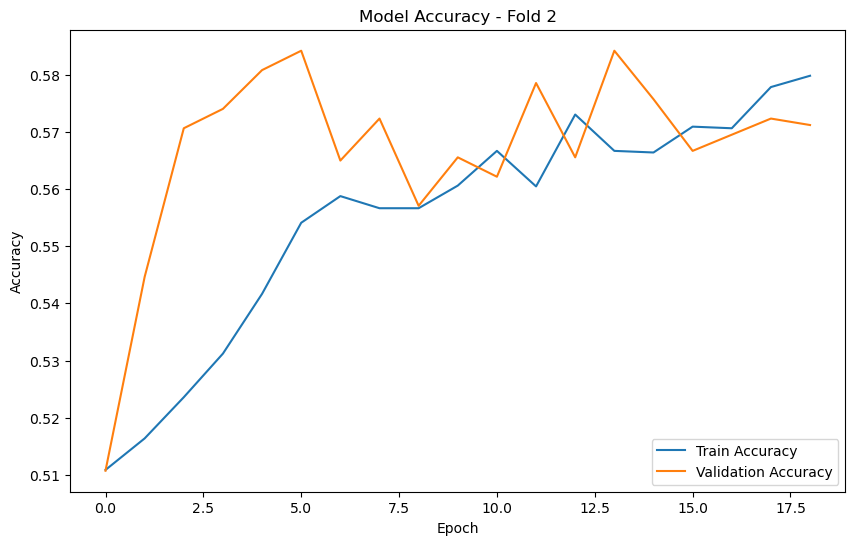

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 2 Results:
Accuracy: 0.5842
Balanced Accuracy: 0.5709
MCC: 0.1573
Sensitivity: 0.7840
Specificity: 0.3578

Fold 3/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5016 - loss: 0.7148 - val_accuracy: 0.5119 - val_loss: 0.6914 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5089 - loss: 0.6966 - val_accuracy: 0.5243 - val_loss: 0.6907 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5279 - loss: 0.6909 - val_accuracy: 0.5124 - val_loss: 0.6894 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5112 - loss: 0.6931 - val_accuracy: 0.5322 - val_loss: 0.6872 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5416 - loss: 0.6883 - val_accuracy: 0.5373 - val_loss: 0.6849 - learning_rate: 5.0000e-04
Epoch 6/50
111/

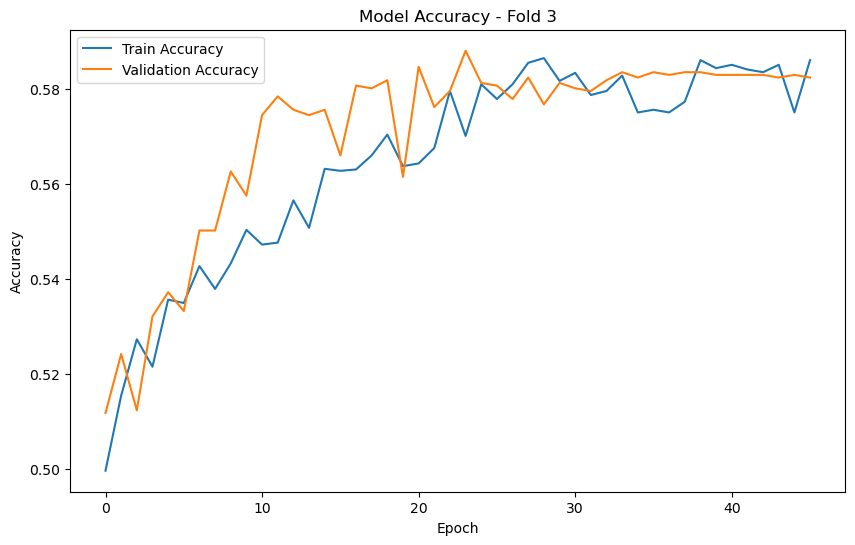

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.5831
Balanced Accuracy: 0.5820
MCC: 0.1690
Sensitivity: 0.7032
Specificity: 0.4607

Fold 4/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.4957 - loss: 0.7029 - val_accuracy: 0.5209 - val_loss: 0.6911 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5045 - loss: 0.6935 - val_accuracy: 0.5249 - val_loss: 0.6909 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5267 - loss: 0.6909 - val_accuracy: 0.5328 - val_loss: 0.6862 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5390 - loss: 0.6833 - val_accuracy: 0.5395 - val_loss: 0.6831 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5349 - loss: 0.6842 - val_accuracy: 0.5356 - val_loss: 0.6832 - learning_rate: 5.0000e-04
Epoch 6/50
111

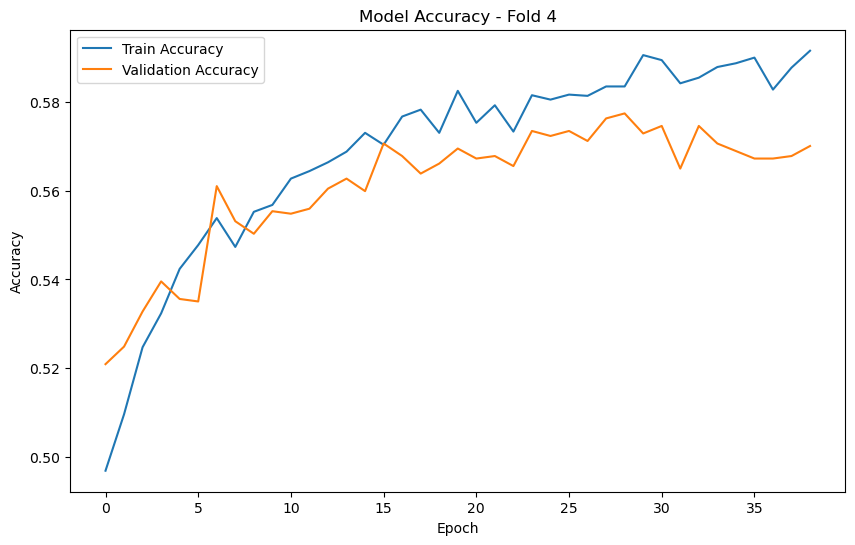

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Results:
Accuracy: 0.5706
Balanced Accuracy: 0.5721
MCC: 0.1590
Sensitivity: 0.7838
Specificity: 0.3603

Fold 5/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.5092 - loss: 0.7087 - val_accuracy: 0.5446 - val_loss: 0.6887 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5324 - loss: 0.6890 - val_accuracy: 0.5531 - val_loss: 0.6870 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5353 - loss: 0.6867 - val_accuracy: 0.5412 - val_loss: 0.6858 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5446 - loss: 0.6842 - val_accuracy: 0.5616 - val_loss: 0.6841 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5411 - loss: 0.6832 - val_accuracy: 0.5542 - val_loss: 0.6832 - learning_rate: 5.0000e-04
Epoch 6/50
111/

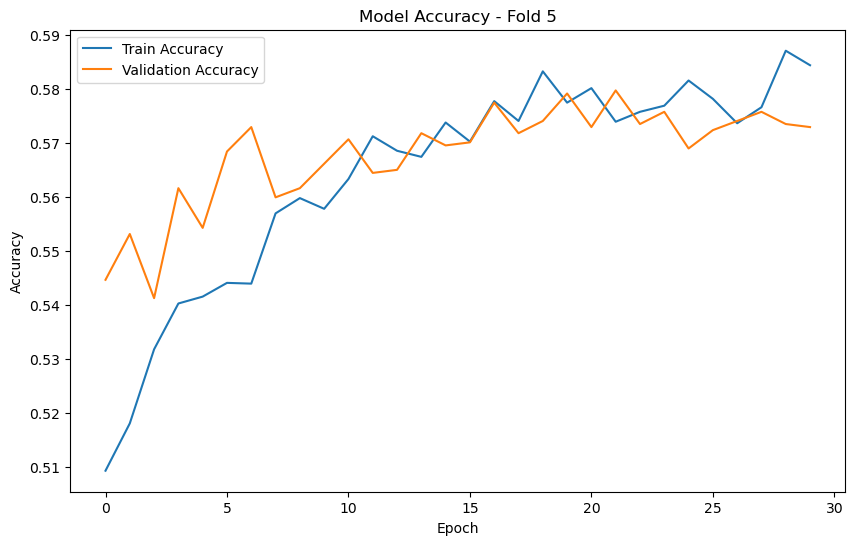

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 5 Results:
Accuracy: 0.5689
Balanced Accuracy: 0.5628
MCC: 0.1342
Sensitivity: 0.7380
Specificity: 0.3876

Average Cross-validation Results:
ACC: 0.5788 ± 0.0075
BALANCED_ACC: 0.5716 ± 0.0061
MCC: 0.1542 ± 0.0115
SN: 0.7539 ± 0.0305
SP: 0.3892 ± 0.0375

Final Test Set Results:
Accuracy: 0.4885
Balanced Accuracy: 0.5652
MCC: 0.0740
Sensitivity: 0.6583
Specificity: 0.4722
Confusion Matrix:
[[1179 1318]
 [  82  158]]


In [30]:
if __name__ == "__main__":
    model = train_and_evaluate()

In [31]:
def create_structure_model(window_size=33, n_features=12):
    """More complex model with strong regularization"""
    inputs = tf.keras.layers.Input(shape=(window_size, n_features))
    
    # Initial feature processing
    x = tf.keras.layers.BatchNormalization()(inputs)
    
    # CNN branch for local features
    conv1 = tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    
    conv2 = tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=5,
        padding='same',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation('relu')(conv2)
    
    # Combine CNN features
    x = tf.keras.layers.Concatenate()([conv1, conv2])
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # BiLSTM for sequential features
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            64,
            return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.l2(0.01),
            recurrent_regularizer=tf.keras.regularizers.l2(0.01)
        )
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Attention mechanism
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=4,
        key_dim=32,
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x, x)
    x = tf.keras.layers.Add()([x, attention])
    x = tf.keras.layers.LayerNormalization()(x)
    
    # Extract central window (K residue ± 2 positions)
    central_pos = window_size // 2
    x = tf.keras.layers.Lambda(
        lambda x: x[:, central_pos-2:central_pos+3, :]
    )(x)
    
    # Dense feature processing
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output
    outputs = tf.keras.layers.Dense(
        1,
        activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Preparing structure data...

Training data shape: (8850, 33, 12)
Test data shape: (2737, 33, 12)

Class weights: {0: 1.0392202912165336, 1: 0.9636324041811847}

Fold 1/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 204ms/step - accuracy: 0.5224 - loss: 8.7780 - val_accuracy: 0.5881 - val_loss: 6.2097 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.5347 - loss: 5.6680 - val_accuracy: 0.5819 - val_loss: 4.0850 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.5499 - loss: 3.8202 - val_accuracy: 0.5610 - val_loss: 2.9479 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.5561 - loss: 2.7896 - val_accuracy: 0.5638 - val_loss: 2.2434 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━

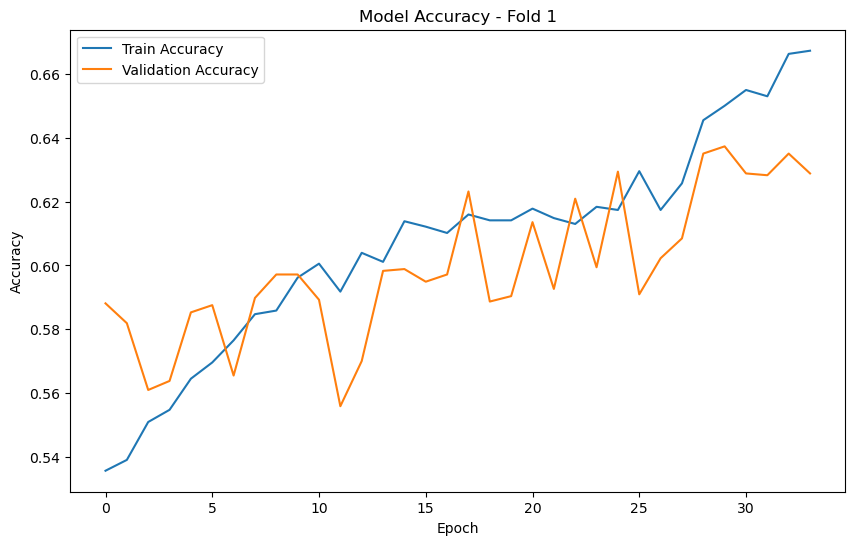

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step

Fold 1 Results:
Accuracy: 0.6350
Balanced Accuracy: 0.6288
MCC: 0.2601
Sensitivity: 0.6981
Specificity: 0.5596

Fold 2/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.5086 - loss: 8.9397 - val_accuracy: 0.5418 - val_loss: 6.5370 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.5331 - loss: 6.0614 - val_accuracy: 0.5226 - val_loss: 4.5007 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.5389 - loss: 4.1740 - val_accuracy: 0.5774 - val_loss: 3.2277 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - accuracy: 0.5582 - loss: 3.0570 - val_accuracy: 0.5768 - val_loss: 2.4708 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step - accuracy: 0.5534 - loss: 2.3838 - val_accuracy: 0.5938 - val_loss: 1.9811 - learning_rate: 5.0000e-04
Epo

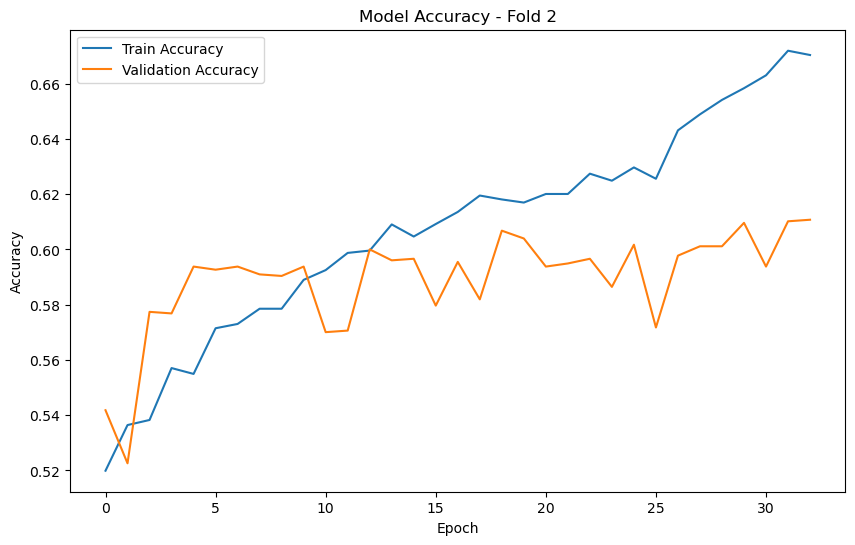

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

Fold 2 Results:
Accuracy: 0.6011
Balanced Accuracy: 0.6020
MCC: 0.2036
Sensitivity: 0.5883
Specificity: 0.6157

Fold 3/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.5148 - loss: 8.7889 - val_accuracy: 0.5548 - val_loss: 6.2277 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.5338 - loss: 5.7054 - val_accuracy: 0.5876 - val_loss: 4.1224 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.5400 - loss: 3.8281 - val_accuracy: 0.5819 - val_loss: 2.8952 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.5425 - loss: 2.7442 - val_accuracy: 0.5977 - val_loss: 2.1951 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.5607 - loss: 2.1172 - val_accuracy: 0.5853 - val_loss: 1.7772 - learning_rate: 5.0000e-04
Epo

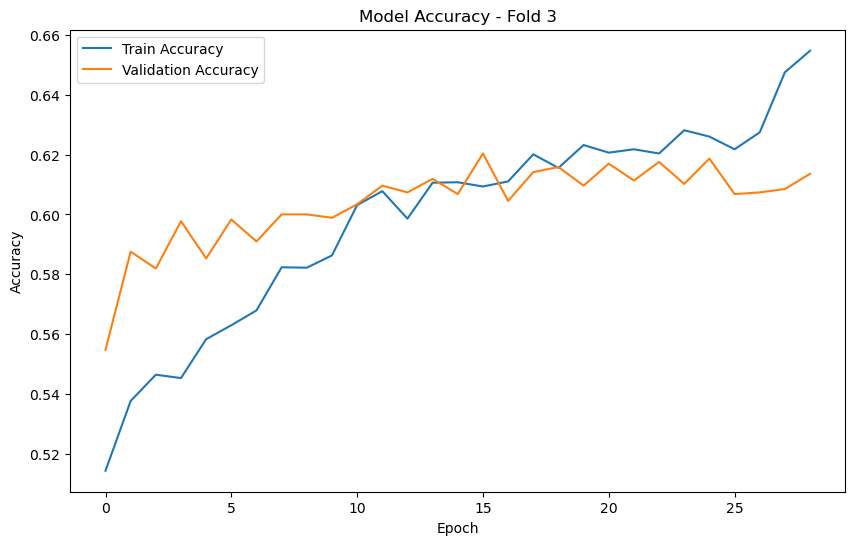

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

Fold 3 Results:
Accuracy: 0.6102
Balanced Accuracy: 0.6091
MCC: 0.2252
Sensitivity: 0.7324
Specificity: 0.4857

Fold 4/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.5205 - loss: 8.8889 - val_accuracy: 0.5616 - val_loss: 6.4165 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.5409 - loss: 5.9420 - val_accuracy: 0.5819 - val_loss: 4.3987 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.5326 - loss: 4.1218 - val_accuracy: 0.5593 - val_loss: 3.1742 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.5428 - loss: 3.0144 - val_accuracy: 0.5718 - val_loss: 2.4245 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.5668 - loss: 2.3259 - val_accuracy: 0.5785 - val_loss: 1.9455 - learning_rate: 5.0000e-04
Epo

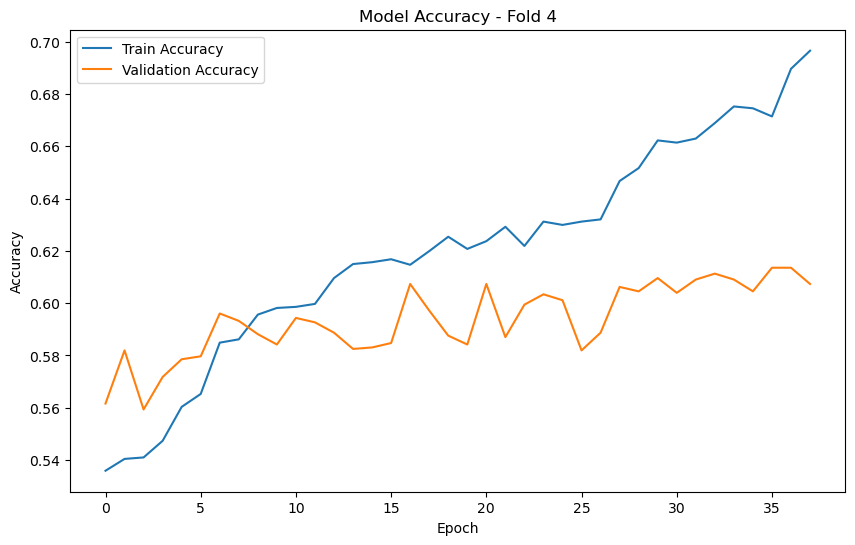

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

Fold 4 Results:
Accuracy: 0.6113
Balanced Accuracy: 0.6115
MCC: 0.2235
Sensitivity: 0.6439
Specificity: 0.5791

Fold 5/5
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 32s 205ms/step - accuracy: 0.5190 - loss: 8.9204 - val_accuracy: 0.5254 - val_loss: 6.5381 - learning_rate: 5.0000e-04
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.5203 - loss: 6.0521 - val_accuracy: 0.5446 - val_loss: 4.5007 - learning_rate: 5.0000e-04
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.5460 - loss: 4.2050 - val_accuracy: 0.5729 - val_loss: 3.2836 - learning_rate: 5.0000e-04
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.5695 - loss: 3.0755 - val_accuracy: 0.5655 - val_loss: 2.5013 - learning_rate: 5.0000e-04
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.5650 - loss: 2.3836 - val_accuracy: 0.5763 - val_loss: 2.0050 - learning_rate: 5.0000e-04
Epo

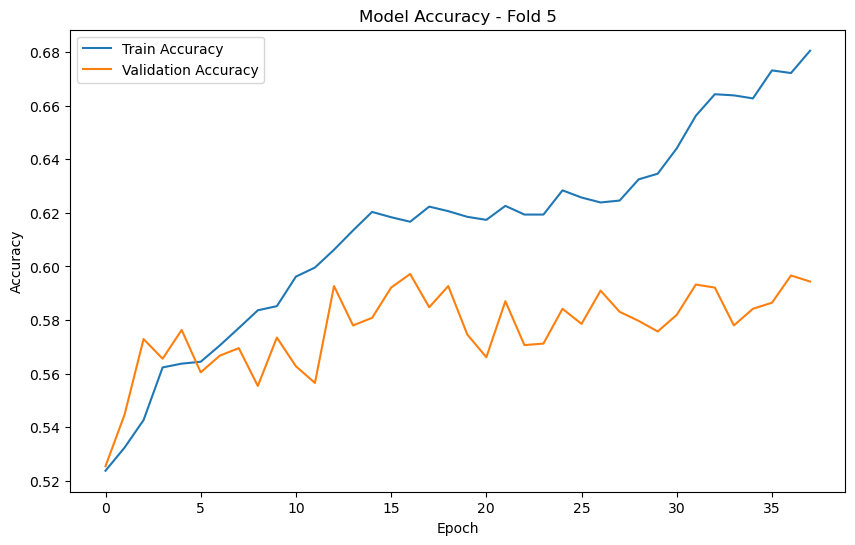

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step

Fold 5 Results:
Accuracy: 0.5921
Balanced Accuracy: 0.5925
MCC: 0.1848
Sensitivity: 0.5819
Specificity: 0.6030

Average Cross-validation Results:
ACC: 0.6099 ± 0.0143
BALANCED_ACC: 0.6088 ± 0.0120
MCC: 0.2194 ± 0.0251
SN: 0.6489 ± 0.0593
SP: 0.5686 ± 0.0457

Final Test Set Results:
Accuracy: 0.6131
Balanced Accuracy: 0.6147
MCC: 0.1321
Sensitivity: 0.6167
Specificity: 0.6127
Confusion Matrix:
[[1530  967]
 [  92  148]]


In [32]:
if __name__ == "__main__":
    model = train_and_evaluate()